In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

from src.utils import compute_loss
from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

# 数据预处理

In [2]:
class UcrDataset(Dataset):
    def __init__(self,filepath):
        xy = np.loadtxt(filepath,delimiter='\t',dtype=np.float32)
        # 此时取出来的数据是一个(N,M)的元组，N是行，M是列，xy.shape[0]可以把N取出来，也就是一共有多少行，有多少条数据
        self.len = xy.shape[0]
        self.x_data = torch.from_numpy(xy[:,1:])
        self.y_data = torch.from_numpy(xy[:,0])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

dataset = UcrDataset('C:\\Users\\14344\Desktop\\数据集\\UCRArchive_2018\\UCRArchive_2018\\ACSF1\ACSF1_TRAIN.tsv')
train_loader = DataLoader(dataset=dataset,batch_size=20,shuffle=False)

In [3]:
dataset.x_data.shape

torch.Size([100, 1460])

In [4]:
train_size = 1460

In [5]:
train_size

1460

In [6]:
test_size = 10

In [66]:
test_size

10

# Transformer Parameters

In [7]:
d_model = 512  # Embedding Size/字嵌入 & 位置嵌入的维度
d_ff = 2048 # FeedForward dimension/FeedForward 层隐藏神经元个数
d_k = d_v = 64  # dimension of K(=Q), V/Q、K、V 向量的维度，其中 Q 与 K 的维度必须相等，V 的维度没有限制，不过为了方便起见，我都设为 64
n_layers = 6  # number of Encoder of Decoder Layer/Encoder 和 Decoder 的个数
n_heads = 8  # number of heads in Multi-Head Attention/多头注意力中 head 的数量
EPOCHS = 3000

# Positional Encoding

In [9]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)#( max_len, 1 )
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)#( max_len, 1, d_model )
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Pad Mask

In [10]:

def get_attn_pad_mask(seq_q, seq_k):
    '''
    seq_q: [batch_size, seq_len]
    seq_k: [batch_size, seq_len]
    seq_len could be src_len or it could be tgt_len
    seq_len in seq_q and seq_len in seq_k maybe not equal
    '''
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # [batch_size, 1, len_k], False is masked
    
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # [batch_size, len_q, len_k]

# Subsequence Mask

In [11]:

def get_attn_subsequence_mask(seq):
    '''
    seq: [batch_size, tgt_len]
    '''
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1) # Upper triangular matrix/上三角矩阵
    
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    return subsequence_mask # [batch_size, tgt_len, tgt_len]

# ScaledDotProductAttention

In [8]:

class ScaledDotProductAttention(nn.Module):
    '''
    通过 Q 和 K 计算出 scores，然后将 scores 和 V 相乘，得到每个单词的 context vector
    '''
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
    
    def forward(self, Q, K, V):
    #def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, d_k]
        K: [batch_size, n_heads, d_k]
        V: [batch_size, n_heads, d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size, n_heads, len_k]
        #scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True./使用mask为True的值填充self张量的元素。
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) # [batch_size, n_heads, d_v]
        return context, attn

# MultiHeadAttention

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
    def forward(self, input_Q, input_K, input_V):
    #def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size/16, d_model/512]
        input_K: [batch_size/16, d_model/512]
        input_V: [batch_size/16, d_model/512]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, n_heads, d_k).transpose(1,2)  # Q: [batch_size/16, n_heads/8,  d_k/64]
        K = self.W_K(input_K).view(batch_size, n_heads, d_k).transpose(1,2)  # K: [batch_size/16, n_heads/8,  d_k/64]
        V = self.W_V(input_V).view(batch_size, n_heads, d_v).transpose(1,2)  # V: [batch_size/16, n_heads/8,  d_v/64]
        #import pdb; 
        #pdb.set_trace()[batch_size/16, n_heads/8, d_k/64]
        #attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]
        
        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        #context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        context, attn = ScaledDotProductAttention()(Q, K, V)
        #import pdb; 
        #pdb.set_trace()
        #context = context.transpose(1, 2).reshape(batch_size, n_heads * d_v) # context: [batch_size, len_q, n_heads * d_v]
        context = context.reshape(batch_size, n_heads * d_v) # context: [batch_size, n_heads * d_v]
        output = self.fc(context) # [batch_size, d_model]
        #import pdb; 
        #pdb.set_trace()
        #return [16, 512]
        return nn.LayerNorm(d_model).cuda()(output + residual), attn

#  FeedForward Layer

In [10]:

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False)
        )
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).cuda()(output + residual) # [batch_size, seq_len, d_model]

# Encoder Layer

In [11]:

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    #def forward(self, enc_inputs, enc_self_attn_mask):
    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size/16, d_model/512]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        #enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs) # enc_inputs to same Q,K,V
        #import pdb; 
        #pdb.set_trace()[batch_size/16, src_len/16, d_model/512]
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size, src_len, d_model]
        #import pdb; 
        #pdb.set_trace()
        return enc_outputs, attn

# Encoder

In [12]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Linear(train_size, d_model)
        #self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        '''
        #import pdb; 
        #pdb.set_trace()
        enc_outputs = self.src_emb(enc_inputs) # [batch_size/16, d_model/512]
        #enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
        #enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]
        enc_self_attns = []
        for layer in self.layers:
            # enc_outputs: [batch_size/16, src_len/16, d_model/512], enc_self_attn: [batch_size, n_heads, src_len, src_len]
            #enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_outputs, enc_self_attn = layer(enc_outputs)
            enc_self_attns.append(enc_self_attn)
        #import pdb; 
        #pdb.set_trace()[batch_size/16, src_len/16, d_model/512]
        return enc_outputs, enc_self_attns

# Decoder Layer

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    #def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
    def forward(self, dec_outputs, enc_outputs):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask: [batch_size, tgt_len, src_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        #dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_outputs, dec_outputs, dec_outputs)
        
        # dec_outputs: [batch_size, tgt_len, d_model], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
        #dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs)
        dec_outputs = self.pos_ffn(dec_outputs) # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn, dec_enc_attn

# Decoder

In [14]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        #self.tgt_emb = nn.Linear(test_size, d_model)
        #self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self,dec_outputs, enc_outputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        enc_intpus: [batch_size, src_len]
        enc_outputs: [batsh_size, src_len, d_model]
        '''
        #import pdb; 
        #pdb.set_trace()
        #dec_outputs = self.tgt_emb(dec_inputs) # [batch_size, tgt_len, d_model]
        #dec_outputs = self.pos_emb(dec_outputs.transpose(0, 1)).transpose(0, 1).cuda() # [batch_size, tgt_len, d_model]
        #dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).cuda() # [batch_size, tgt_len, tgt_len]
        #dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs).cuda() # [batch_size, tgt_len, tgt_len]
        #dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0).cuda() # [batch_size, tgt_len, tgt_len]

        #dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs) # [batc_size, tgt_len, src_len]

        
        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            #dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

# Transformer

In [15]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder().cuda()
        self.decoder = Decoder().cuda()
        self.projection = nn.Linear(d_model, test_size, bias=False).cuda()
    def forward(self, enc_inputs, dec_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        dec_inputs: [batch_size, tgt_len]
        '''
        # tensor to store decoder outputs
        # outputs = torch.zeros(batch_size, tgt_len, test_size).to(self.device)
        
        # enc_outputs: [batch_size, src_len, d_model], enc_self_attns: [n_layers, batch_size, n_heads, src_len, src_len]
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs = enc_outputs
        # dec_outpus: [batch_size, tgt_len, d_model], dec_self_attns: [n_layers, batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [n_layers, batch_size, tgt_len, src_len]
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_outputs, enc_outputs)
        #import pdb; 
        #pdb.set_trace()
        dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, test_size]
        #import pdb; 
        #pdb.set_trace()
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

# 模型 & 损失函数 & 优化器

In [16]:
model = Transformer().cuda()
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.99)

# Train

[Epoch  68/3000]: 100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 260.64it/s, loss=0.319]


[Epoch 136/3000]: 100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 261.71it/s, loss=0.629]


[Epoch 204/3000]: 100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 267.59it/s, loss=0.401]


[Epoch 272/3000]: 100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 268.89it/s, loss=0.37]


[Epoch 340/3000]: 100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 258.42it/s, loss=0.0931]


[Epoch 408/3000]: 100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 267.80it/s, loss=0.201]


[Epoch 476/3000]: 100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 274.26it/s, loss=0.147]


[Epoch 544/3000]: 100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 264.58it/s, loss=0.25]


[Epoch 612/3000]: 100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 269.48it/s, loss=0.0191]


[Epoch 680/3000]: 100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 258.16it/s, loss=0.423]


[Epoch 748/3000]: 100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 265.20it/s, loss=0.51]


[Epoch 816/3000]: 100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 265.10it/s, loss=0.0712]


[Epoch 884/3000]: 100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 254.25it/s, loss=0.179]


[Epoch 952/3000]: 100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 255.62it/s, loss=0.414]


[Epoch 1020/3000]: 100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 254.51it/s, loss=0.0536]


[Epoch 1088/3000]: 100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 262.08it/s, loss=0.487]


[Epoch 1156/3000]: 100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 265.77it/s, loss=0.0562]


[Epoch 1224/3000]: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 251.20it/s, loss=0.00851]


[Epoch 1292/3000]: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 257.51it/s, loss=0.00331]


[Epoch 1360/3000]: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 260.78it/s, loss=0.00212]


[Epoch 1428/3000]: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 268.69it/s, loss=0.00158]


[Epoch 1496/3000]: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 282.71it/s, loss=0.00125]


[Epoch 1564/3000]: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 278.12it/s, loss=0.00104]


[Epoch 1632/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 264.87it/s, loss=0.000886]


[Epoch 1700/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 267.58it/s, loss=0.000771]


[Epoch 1768/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 274.15it/s, loss=0.000682]


[Epoch 1836/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 273.92it/s, loss=0.000611]


[Epoch 1904/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 260.32it/s, loss=0.000553]


[Epoch 1972/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 280.94it/s, loss=0.000505]


[Epoch 2040/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 275.97it/s, loss=0.000464]


[Epoch 2108/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 270.93it/s, loss=0.000429]


[Epoch 2176/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 270.50it/s, loss=0.000399]


[Epoch 2244/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 273.02it/s, loss=0.000373]


[Epoch 2312/3000]: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 266.04it/s, loss=0.00035]


[Epoch 2380/3000]: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 275.76it/s, loss=0.00033]


[Epoch 2448/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 269.15it/s, loss=0.000312]


[Epoch 2516/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 271.14it/s, loss=0.000295]


[Epoch 2584/3000]: 100%|██████████████████████████████████████████████| 100/100 [00:00<00:00, 267.13it/s, loss=0.00028]


[Epoch 2652/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 267.77it/s, loss=0.000267]


[Epoch 2720/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 271.95it/s, loss=0.000255]


[Epoch 2788/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 269.05it/s, loss=0.000243]


[Epoch 2856/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 258.55it/s, loss=0.000233]


[Epoch 2924/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 279.01it/s, loss=0.000224]


[Epoch 2992/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 271.34it/s, loss=0.000215]


[Epoch 3000/3000]: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 270.58it/s, loss=0.000214]


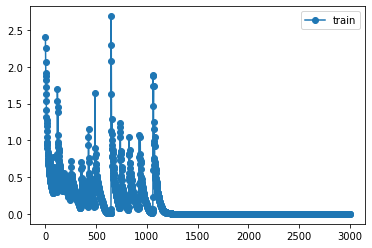

In [17]:
hist_loss = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_loader.dataset), desc=f"[Epoch {epoch+1:3d}/{EPOCHS}]") as pbar:
        #for x_inputs, y_inputs in train_loader:
        for idx_batch, (x_inputs, y_inputs) in enumerate(train_loader):
            '''
            enc_inputs: [batch_size, src_len]
            dec_inputs: [batch_size, tgt_len]
            dec_outputs: [batch_size, tgt_len]
            '''
            enc_inputs, dec_inputs, dec_outputs = x_inputs.cuda(), y_inputs.cuda(), y_inputs.cuda()
            # outputs: [batch_size * tgt_len, test_size]
            outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
            #       outputs=torch.tensor(outputs,dtype=torch.int64).cuda()
            #       dec_outputs=torch.tensor(dec_outputs,dtype=torch.int64).cuda()
            #outputs = outputs
            dec_outputs = dec_outputs.long()
            #import pdb; 
            #pdb.set_trace()
            loss = criterion(outputs, dec_outputs)
            #print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x_inputs.shape[0])
            
        train_loss = running_loss/len(train_loader)
        #val_loss = compute_loss(model, dataloader_val, criterion, device).item()
        #pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        pbar.set_postfix({'loss': train_loss})
        
        hist_loss[epoch] = train_loss
        #hist_loss_val[idx_epoch] = val_loss
        
        #if val_loss < val_loss_best:
            #val_loss_best = val_loss
            #torch.save(net.state_dict(), model_save_path)
    
plt.plot(hist_loss, 'o-', label='train')
#plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
#print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

    

# Test

In [82]:
def greedy_decoder(model, enc_input, start_symbol):
    """
    For simplicity, a Greedy Decoder is Beam search when K=1. This is necessary for inference as we don't know the
    target sequence input. Therefore we try to generate the target input word by word, then feed it into the transformer.
    Starting Reference: http://nlp.seas.harvard.edu/2018/04/03/attention.html#greedy-decoding
    :param model: Transformer Model
    :param enc_input: The encoder input
    :param start_symbol: The start symbol. In this example it is 'S' which corresponds to index 4
    :return: The target input
    """
    enc_outputs, enc_self_attns = model.encoder(enc_input)
    dec_input = torch.zeros(1, tgt_len).type_as(enc_input.data)
    next_symbol = start_symbol
    for i in range(0, tgt_len):
        dec_input[0][i] = next_symbol
        dec_outputs, _, _ = model.decoder(dec_input, enc_input, enc_outputs)
        projected = model.projection(dec_outputs)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[i]
        next_symbol = next_word.item()
    return dec_input

# Test
enc_inputs, _, _ = next(iter(train_loader))
greedy_dec_input = greedy_decoder(model, enc_inputs[0].view(1, -1).cuda(), start_symbol=tgt_vocab["S"])
predict, _, _, _ = model(enc_inputs[0].view(1, -1).cuda(), greedy_dec_input)
predict = predict.data.max(1, keepdim=True)[1]
print(enc_inputs[0], '->', [idx2word[n.item()] for n in predict.squeeze()])

ValueError: not enough values to unpack (expected 3, got 2)